In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from muon import atac as ac

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

['default', 'despine']


In [2]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffeb3b', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#aec7e8', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#ffbb78', 'Fev+ Delta,1':'#98df8a',
        'Fev+ Delta,2': '#17becf', 'Ngn3 high cycling': '#aec7e8',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}

In [4]:
output_dir = "."

In [5]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [6]:
adata.uns["celltype_colors"] = [color_dict[ct] for ct in adata.obs["celltype"].cat.categories]

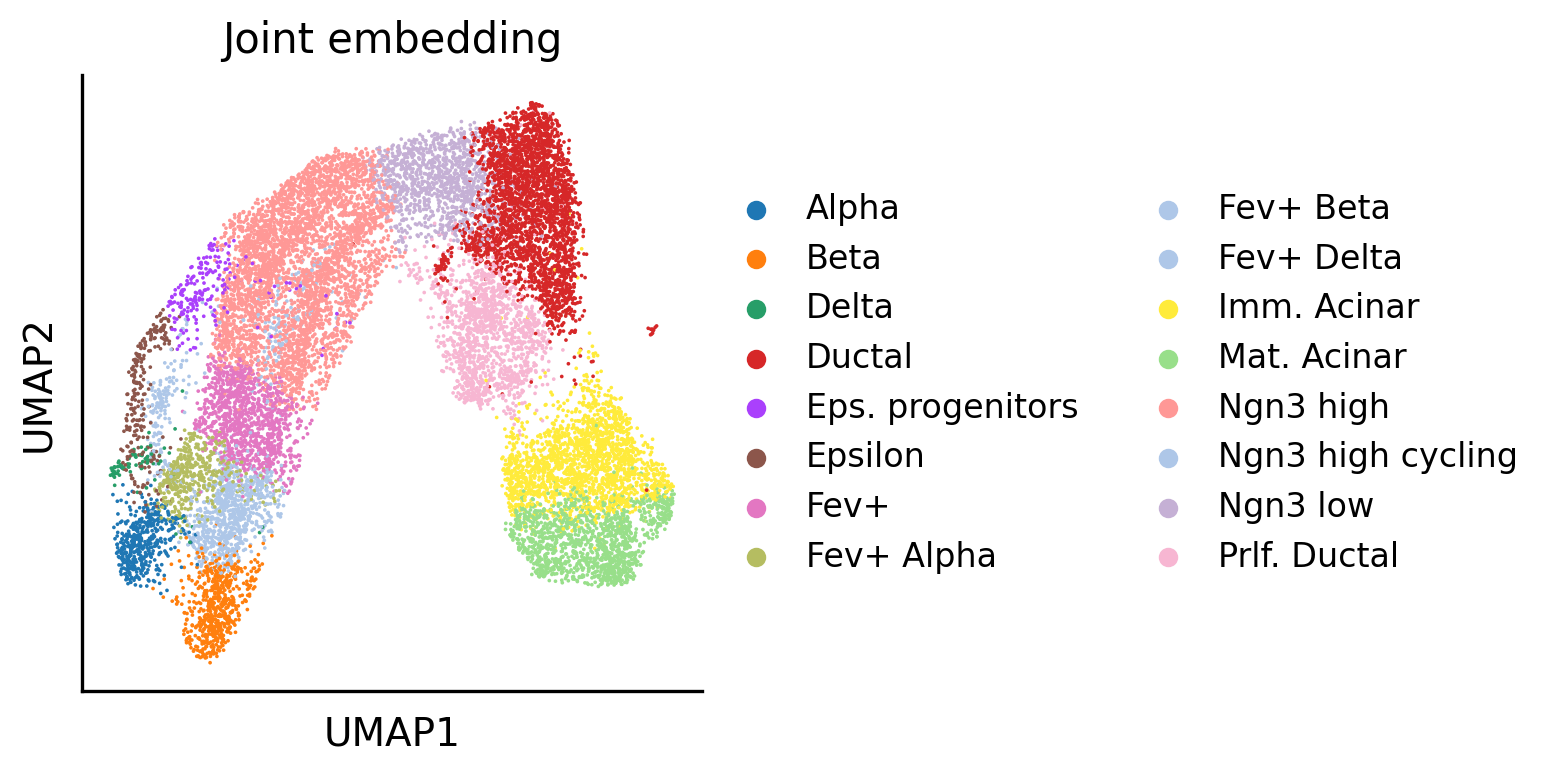

In [7]:
fig = sc.pl.embedding(adata, basis="umap", color=["celltype"], title="Joint embedding", show=True, return_fig=True)
fig

# Refinement based on WNN

In [8]:
sc.tl.leiden(adata, restrict_to=("celltype", ["Fev+ Delta"]), resolution=0.5, key_added="Fev_delta_refinement")

In [9]:
adata.obs["Fev_delta_refinement"].value_counts()

Ngn3 high            3898
Ductal               2906
Imm. Acinar          1928
Prlf. Ductal         1397
Mat. Acinar          1322
Ngn3 low             1176
Fev+                 1134
Fev+ Beta             833
Beta                  588
Alpha                 460
Fev+ Alpha            433
Epsilon               247
Eps. progenitors      204
Ngn3 high cycling     139
Delta                  77
Fev+ Delta,0           61
Fev+ Delta,1           60
Fev+ Delta,2           55
Name: Fev_delta_refinement, dtype: int64

In [10]:
adata.uns["Fev_delta_refinement_colors"] = [color_dict[ct] for ct in adata.obs["Fev_delta_refinement"].cat.categories]

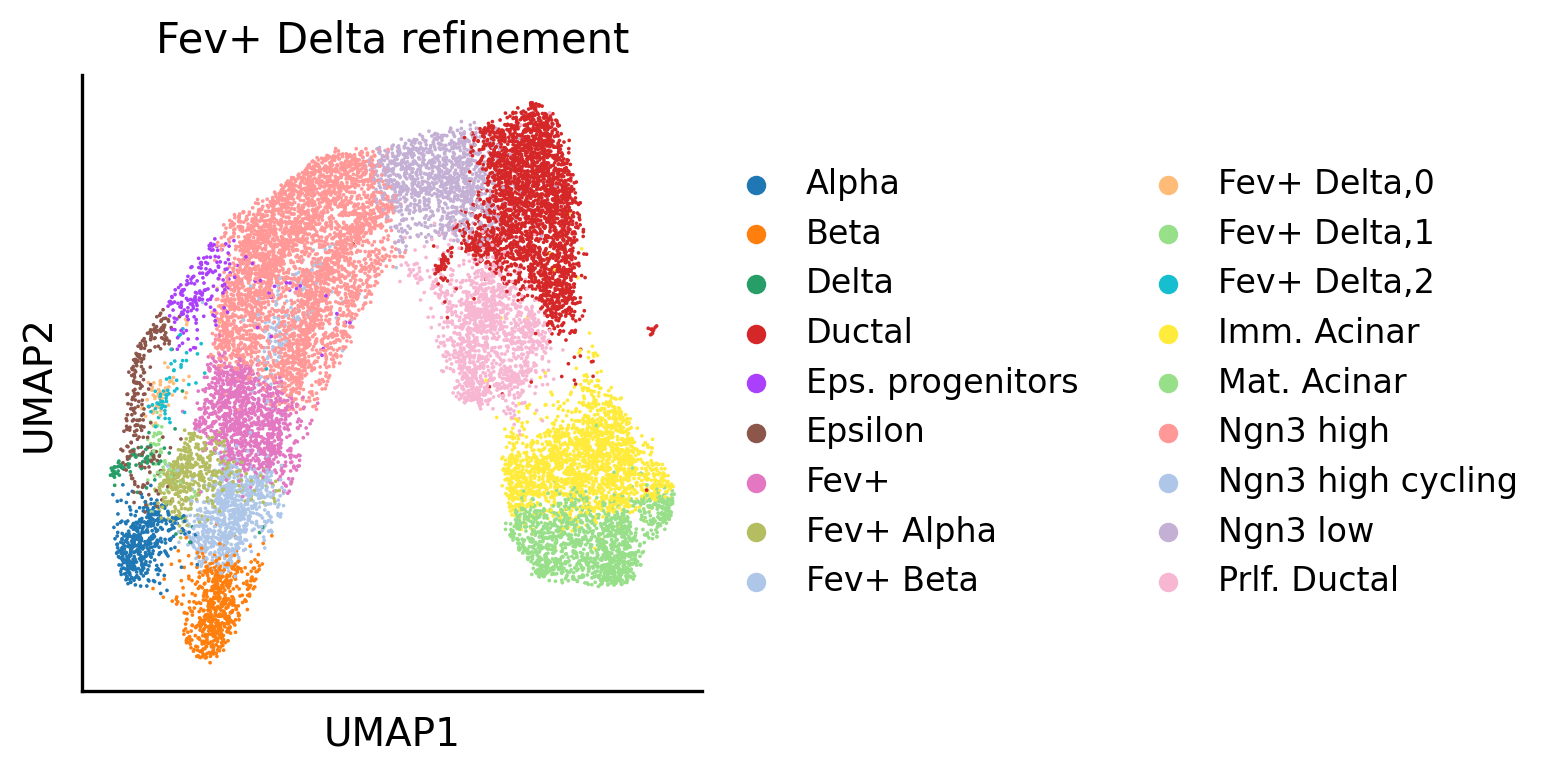

In [11]:
fig = sc.pl.embedding(adata, basis="umap", color=["Fev_delta_refinement"], title="Fev+ Delta refinement", show=True, return_fig=True)
fig

In [12]:
fig.figure.savefig(os.path.join(output_dir, 'fev_delta_refinement.png'))

In [13]:
sc.tl.leiden(adata, restrict_to=("celltype", ["Ngn3 high"]), resolution=0.5, key_added="Ngn3_high_refinement")

In [14]:
adata.obs["Ngn3_high_refinement"].value_counts()

Ductal               2906
Imm. Acinar          1928
Prlf. Ductal         1397
Mat. Acinar          1322
Ngn3 low             1176
Ngn3 high,0          1155
Fev+                 1134
Ngn3 high,1          1097
Fev+ Beta             833
Ngn3 high,2           739
Beta                  588
Alpha                 460
Fev+ Alpha            433
Ngn3 high,3           429
Ngn3 high,4           371
Epsilon               247
Eps. progenitors      204
Fev+ Delta            176
Ngn3 high cycling     139
Ngn3 high,5           107
Delta                  77
Name: Ngn3_high_refinement, dtype: int64

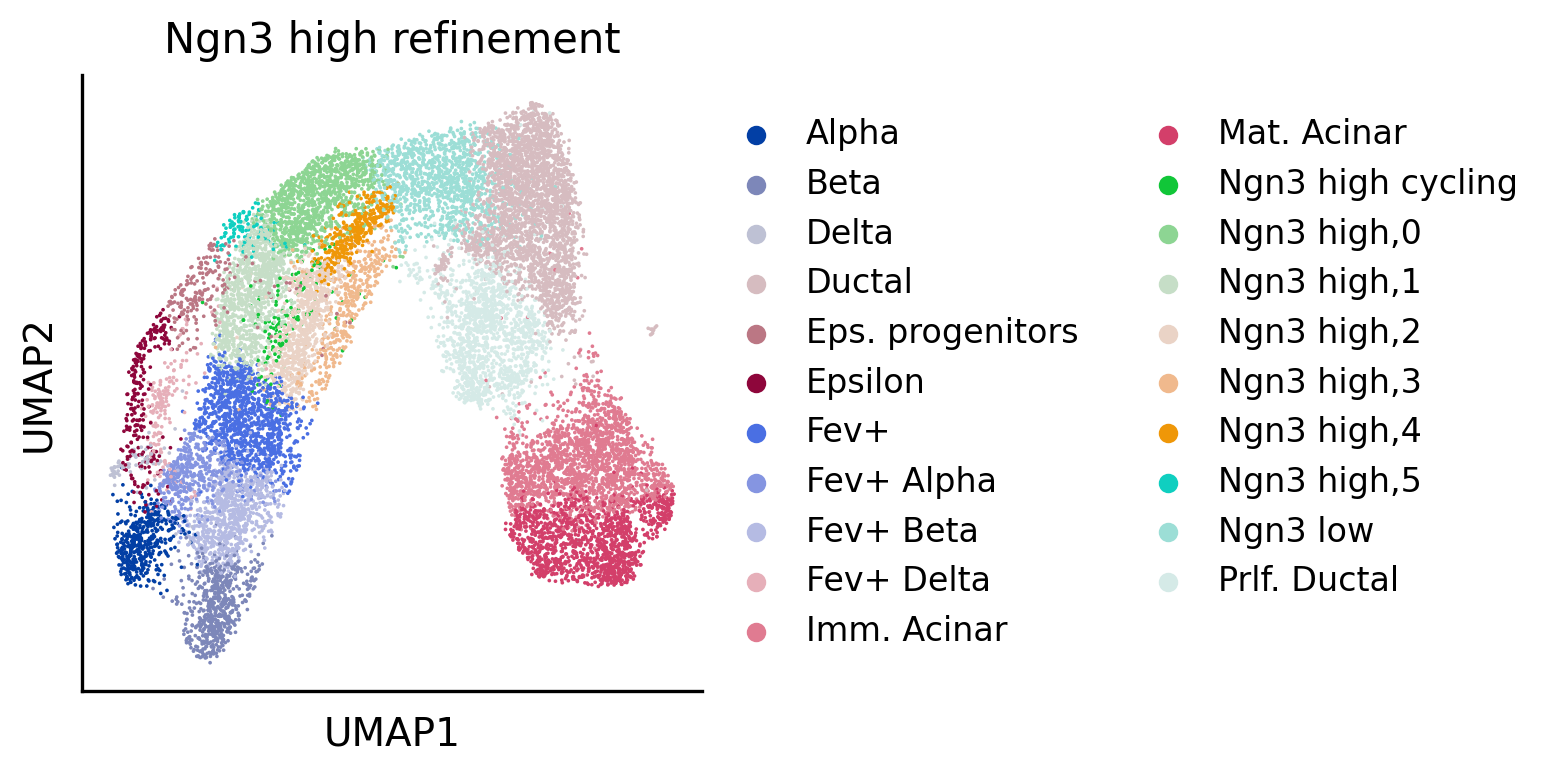

In [15]:
fig = sc.pl.embedding(adata, basis="umap", color=["Ngn3_high_refinement"], title="Ngn3 high refinement", show=True, return_fig=True)
fig

In [16]:
adata.uns["Ngn3_high_refinement_colors"] = [color_dict[ct] if ct in color_dict.keys() else orig_c for ct, orig_c in zip(adata.obs["Ngn3_high_refinement"].cat.categories, adata.uns["Ngn3_high_refinement_colors"])]

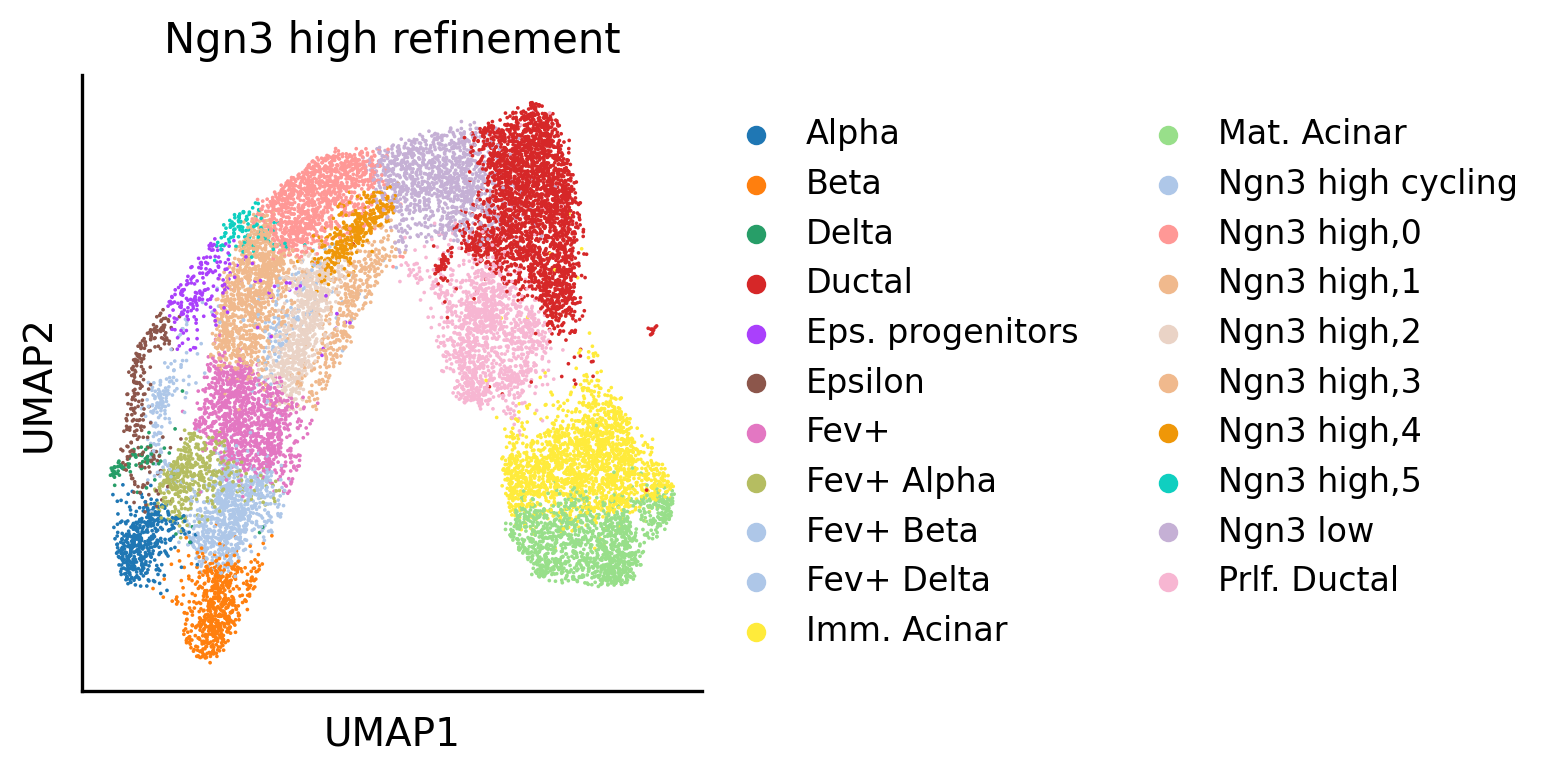

In [17]:
fig = sc.pl.embedding(adata, basis="umap", color=["Ngn3_high_refinement"], title="Ngn3 high refinement", show=True, return_fig=True)
fig

In [18]:
def create_common_refinement(x):
    if x["Ngn3_high_refinement"] in ("Ngn3 high,0", "Ngn3 high,1", "Ngn3 high,2", "Ngn3 high,3", "Ngn3 high,4"):
        return "Ngn3 high,0"
    if x["Ngn3_high_refinement"] == "Ngn3 high,5":
        return "Ngn3 high,1"
    return x["Fev_delta_refinement"]

adata.obs["refinement"] = adata.obs.apply(create_common_refinement, axis=1)

In [19]:
adata.obs["refinement"] = adata.obs["refinement"].astype("category")

In [20]:
adata.uns["refinement_colors"] = [color_dict[ct] for ct in adata.obs["refinement"].cat.categories]

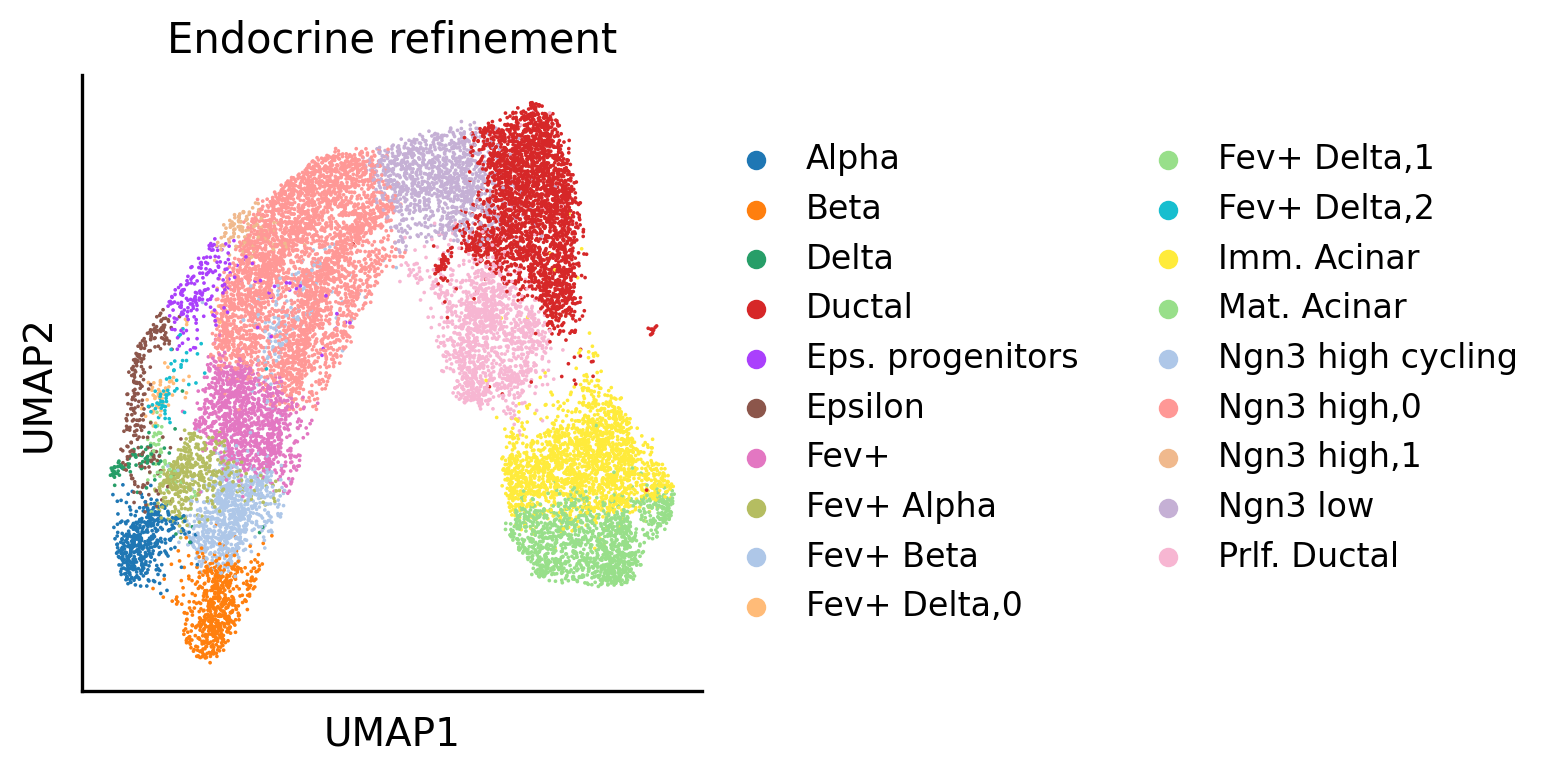

In [21]:
fig = sc.pl.embedding(adata, basis="umap", color=["refinement"], title="Endocrine refinement", show=True, return_fig=True)
fig

In [22]:
fig.figure.savefig(os.path.join(output_dir, 'endocrine_refinement.png'))

# Refinement based on GEX

In [23]:
adata_gex = adata[:, adata.var["modality"]=="GEX"].copy()

In [24]:
del adata_gex.obsm["X_pca"]

In [25]:
sc.pp.normalize_total(adata_gex, target_sum=1e4)
sc.pp.log1p(adata_gex)

In [26]:
sc.pp.neighbors(adata_gex)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [27]:
sc.tl.leiden(adata_gex, restrict_to=("celltype", ["Fev+ Delta"]), resolution=0.4, key_added="Fev_delta_refinement_gex")

In [28]:
adata_gex.obs["Fev_delta_refinement_gex"].value_counts()

Ngn3 high            3898
Ductal               2906
Imm. Acinar          1928
Prlf. Ductal         1397
Mat. Acinar          1322
Ngn3 low             1176
Fev+                 1134
Fev+ Beta             833
Beta                  588
Alpha                 460
Fev+ Alpha            433
Epsilon               247
Eps. progenitors      204
Ngn3 high cycling     139
Fev+ Delta,0           77
Delta                  77
Fev+ Delta,1           56
Fev+ Delta,2           41
Fev+ Delta,3            1
Fev+ Delta,4            1
Name: Fev_delta_refinement_gex, dtype: int64

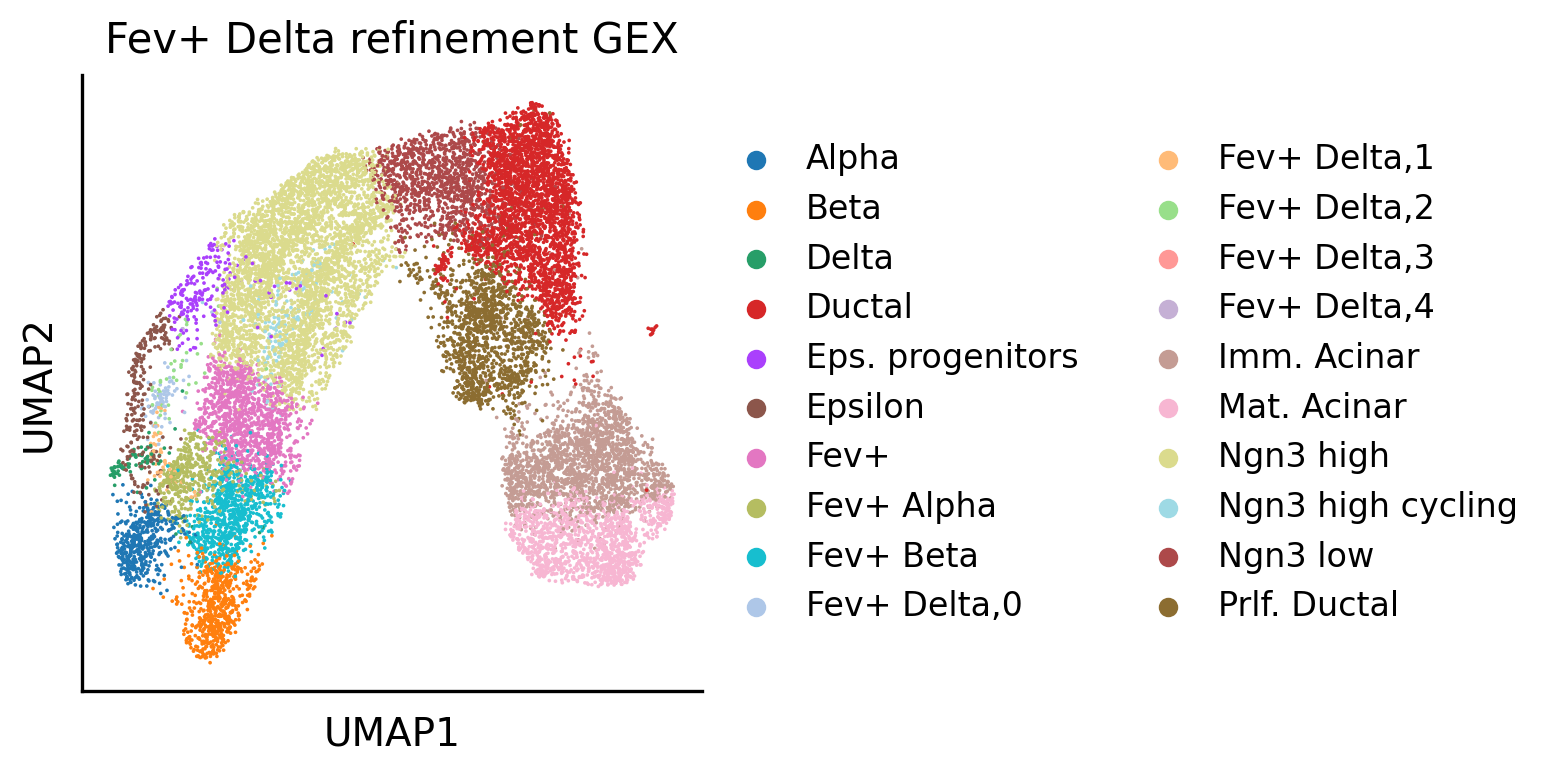

In [29]:
fig = sc.pl.embedding(adata_gex, basis="umap", color=["Fev_delta_refinement_gex"], title="Fev+ Delta refinement GEX", show=True, return_fig=True)
fig

In [30]:
adata.uns["Fev_delta_refinement_gex_colors"] = [color_dict[ct] if ct in color_dict.keys() else orig_c for ct, orig_c in zip(adata_gex.obs["Fev_delta_refinement_gex"].cat.categories, adata_gex.uns["Fev_delta_refinement_gex_colors"])]

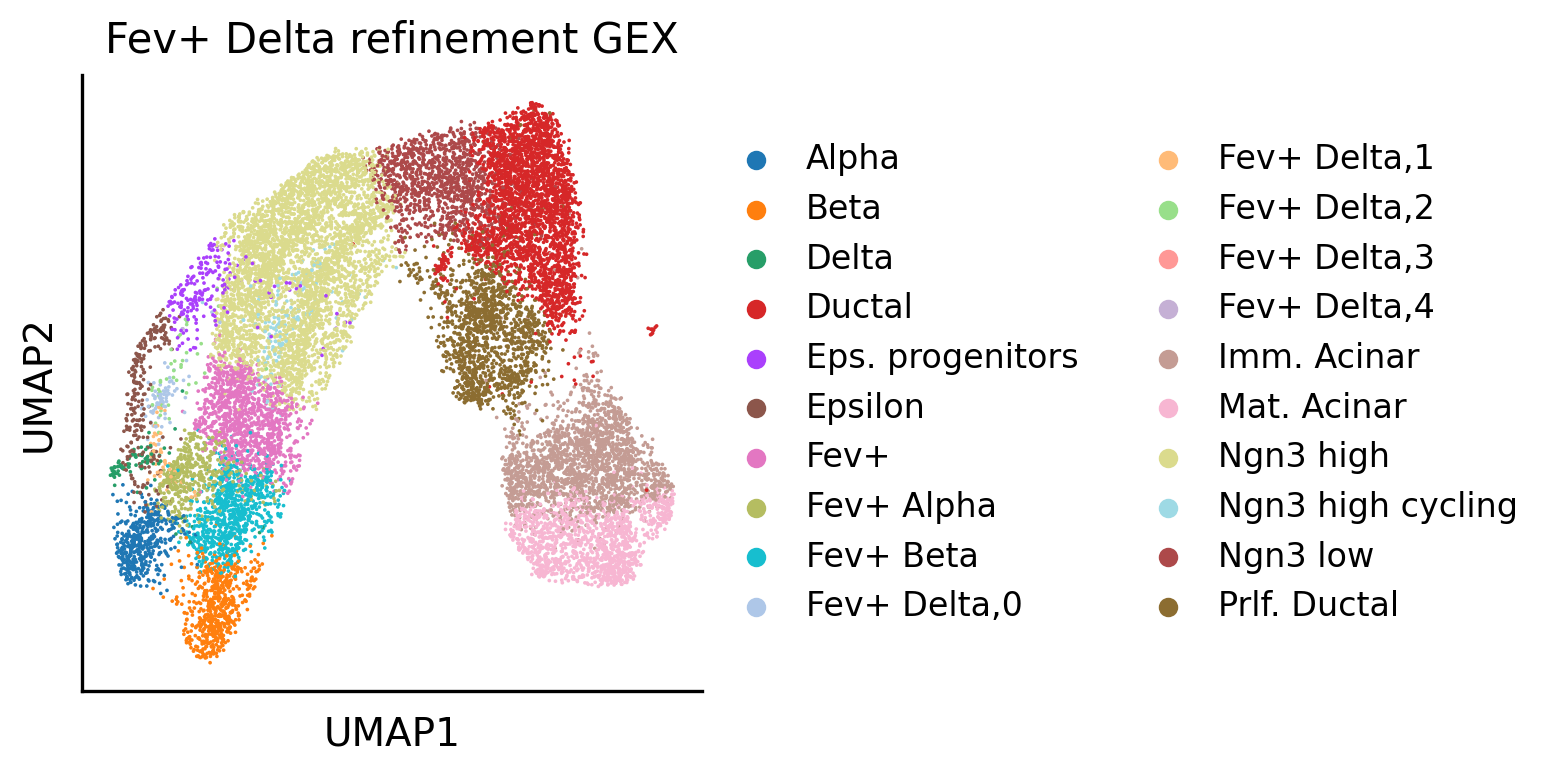

In [31]:
fig = sc.pl.embedding(adata_gex, basis="umap", color=["Fev_delta_refinement_gex"], title="Fev+ Delta refinement GEX", show=True, return_fig=True)
fig

In [32]:
fig.figure.savefig(os.path.join(output_dir, 'fev_delta_refinement_gex.png'))

In [33]:
sc.tl.leiden(adata_gex, restrict_to=("celltype", ["Ngn3 high"]), resolution=0.4, key_added="Ngn3_high_refinement_gex")

In [34]:
adata_gex.obs["Ngn3_high_refinement_gex"].value_counts()

Ductal               2906
Imm. Acinar          1928
Prlf. Ductal         1397
Mat. Acinar          1322
Ngn3 low             1176
Fev+                 1134
Ngn3 high,0          1000
Ngn3 high,1           912
Fev+ Beta             833
Ngn3 high,2           709
Ngn3 high,3           694
Beta                  588
Ngn3 high,4           548
Alpha                 460
Fev+ Alpha            433
Epsilon               247
Eps. progenitors      204
Fev+ Delta            176
Ngn3 high cycling     139
Delta                  77
Ngn3 high,5            27
Ngn3 high,6             7
Ngn3 high,7             1
Name: Ngn3_high_refinement_gex, dtype: int64

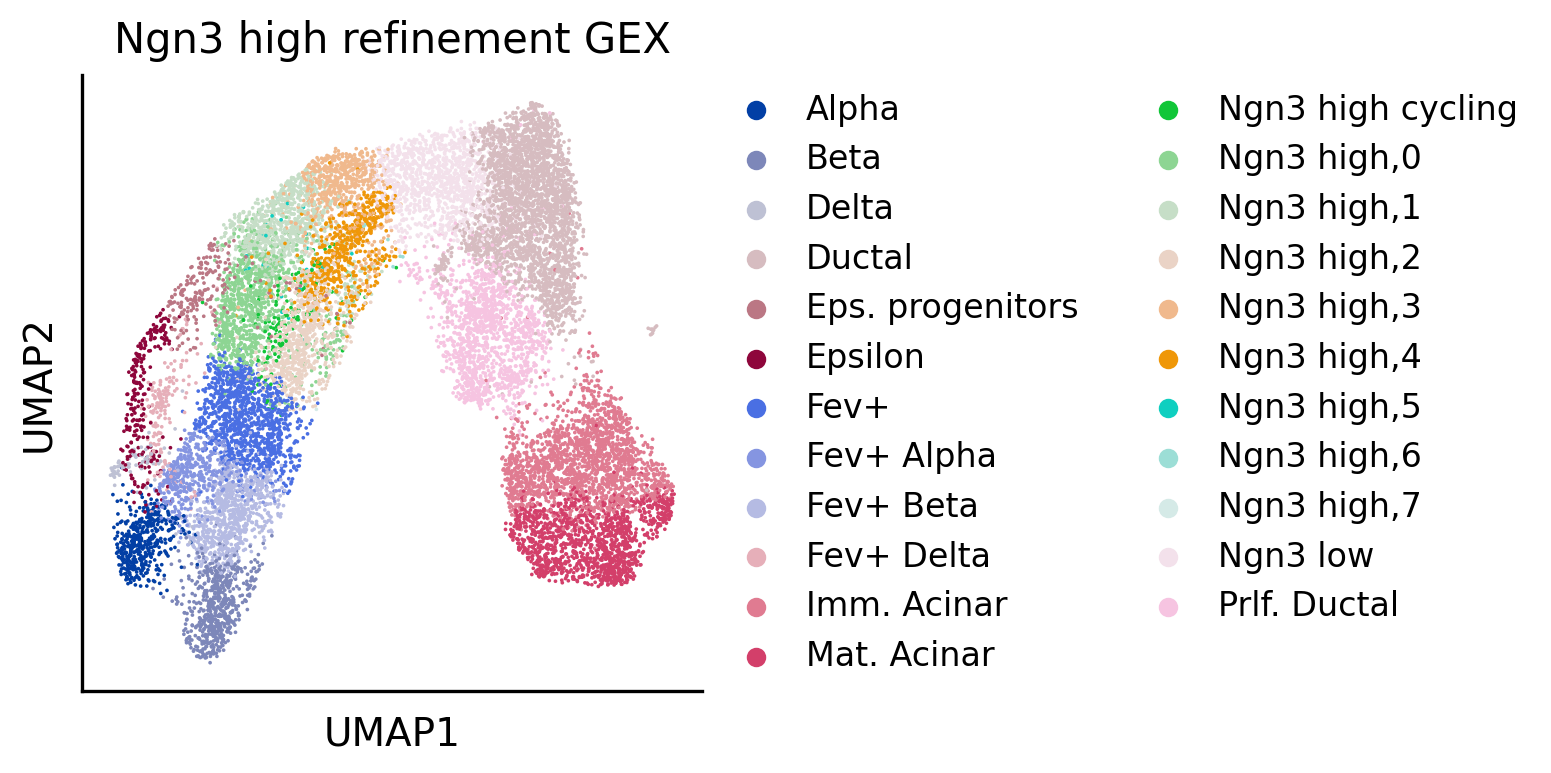

In [35]:
fig = sc.pl.embedding(adata_gex, basis="umap", color=["Ngn3_high_refinement_gex"], title="Ngn3 high refinement GEX", show=True, return_fig=True)
fig

In [36]:
adata_gex.uns["Ngn3_high_refinement_gex_colors"] = [color_dict[ct] if ct in color_dict.keys() else orig_c for ct, orig_c in zip(adata_gex.obs["Ngn3_high_refinement_gex"].cat.categories, adata_gex.uns["Ngn3_high_refinement_gex_colors"])]

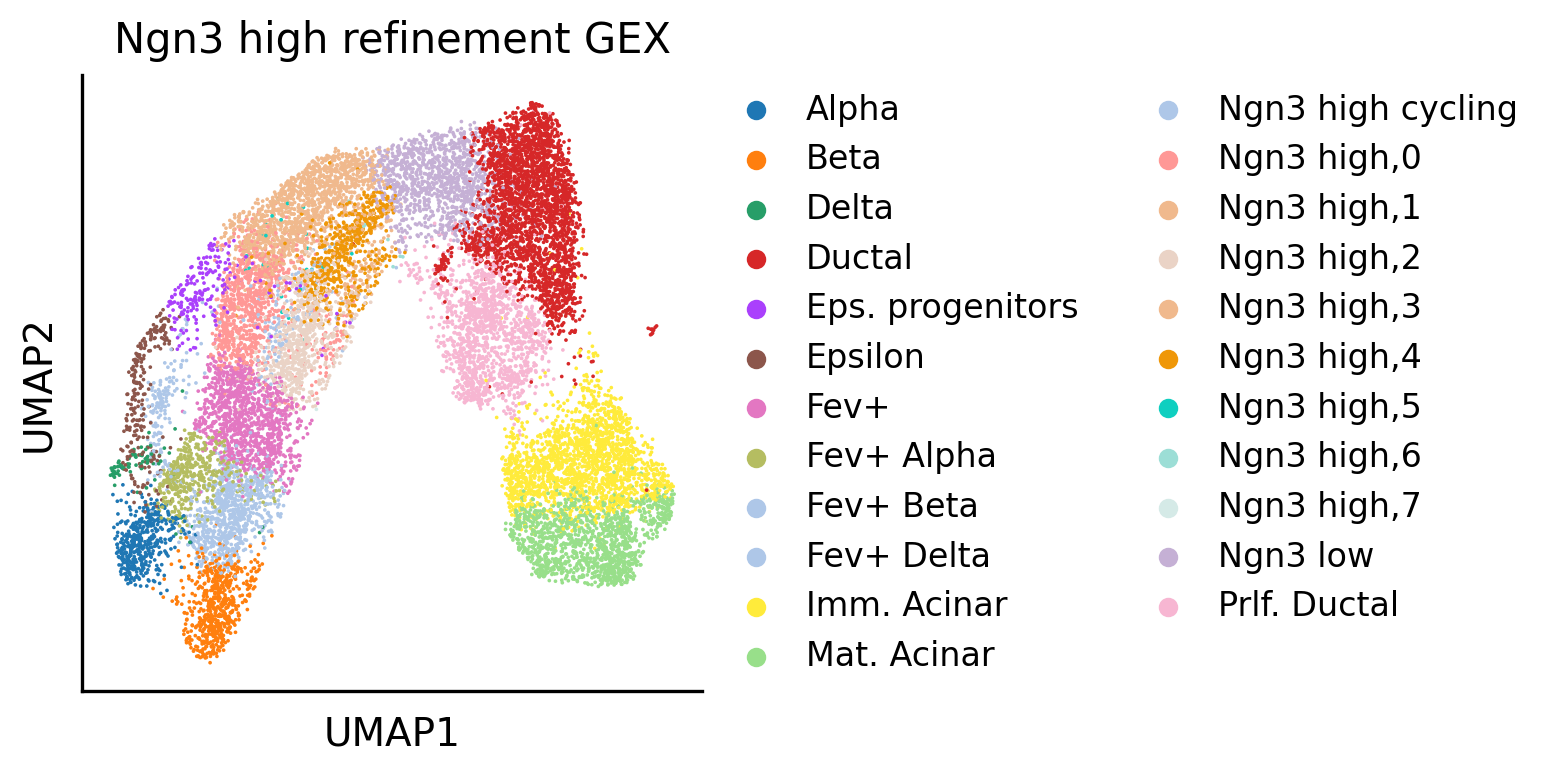

In [37]:
fig = sc.pl.embedding(adata_gex, basis="umap", color=["Ngn3_high_refinement_gex"], title="Ngn3 high refinement GEX", show=True, return_fig=True)
fig

In [38]:
fig.figure.savefig(os.path.join(output_dir, 'ngn3_high_refinement_gex.png'))

# Refinement based on ATAC

In [39]:
adata_atac = adata[:, adata.var["modality"]=="ATAC"].copy()

In [40]:
ac.pp.tfidf(adata_atac, scale_factor=1e4)

In [41]:
sc.pp.normalize_per_cell(adata_atac, counts_per_cell_after=1e4)
sc.pp.log1p(adata_atac)

In [42]:
ac.tl.lsi(adata_atac)

In [43]:
depth_corr = [np.corrcoef(adata_atac.obsm["X_lsi"][:,i], adata_atac.obs["nCount_ATAC"])[1,0] for i in range(adata_atac.obsm["X_lsi"].shape[1])]

In [44]:
comps_to_remove = np.where(np.abs(depth_corr) > 0.4)[0]
comps_to_remove

array([0, 4])

In [45]:
subset = list(set(range(adata_atac.obsm["X_lsi"].shape[1])) - set(comps_to_remove))

In [46]:
adata_atac.obsm['X_lsi'] = adata_atac.obsm['X_lsi'][:,subset]

In [47]:
sc.pp.neighbors(adata_atac, use_rep="X_lsi")

In [48]:
sc.tl.leiden(adata_atac, restrict_to=("celltype", ["Fev+ Delta"]), resolution=0.5, key_added="Fev_delta_refinement_atac")

In [49]:
adata_atac.obs["Fev_delta_refinement_atac"].value_counts()

Ngn3 high            3898
Ductal               2906
Imm. Acinar          1928
Prlf. Ductal         1397
Mat. Acinar          1322
Ngn3 low             1176
Fev+                 1134
Fev+ Beta             833
Beta                  588
Alpha                 460
Fev+ Alpha            433
Epsilon               247
Eps. progenitors      204
Ngn3 high cycling     139
Delta                  77
Fev+ Delta,0           67
Fev+ Delta,1           58
Fev+ Delta,2           50
Fev+ Delta,3            1
Name: Fev_delta_refinement_atac, dtype: int64

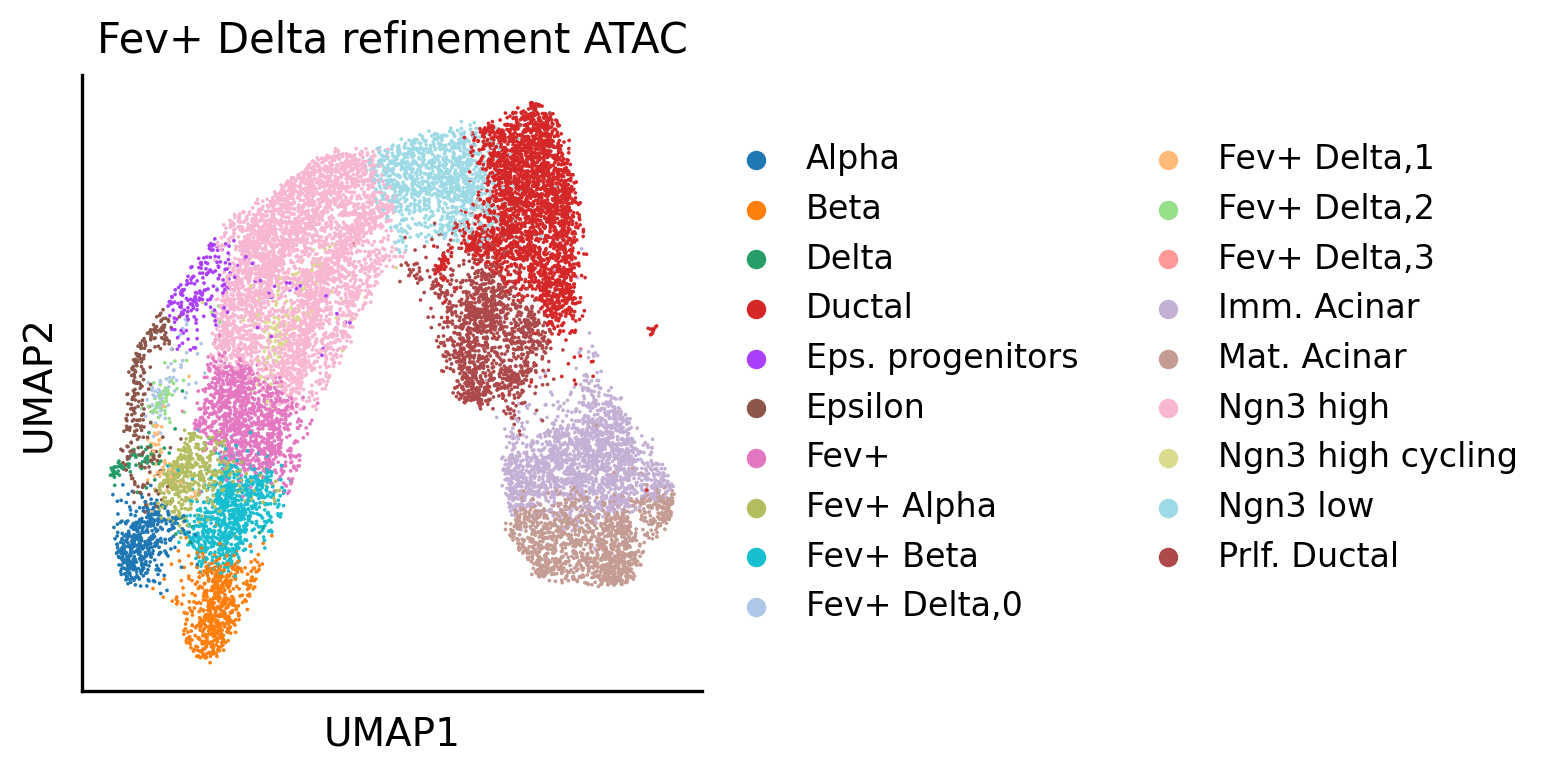

In [50]:
fig = sc.pl.embedding(adata_atac, basis="umap", color=["Fev_delta_refinement_atac"], title="Fev+ Delta refinement ATAC", show=True, return_fig=True)
fig

In [51]:
adata_atac.uns["Fev_delta_refinement_atac_colors"] = [color_dict[ct] if ct in color_dict.keys() else orig_c for ct, orig_c in zip(adata_atac.obs["Fev_delta_refinement_atac"].cat.categories, adata_atac.uns["Fev_delta_refinement_atac_colors"])]

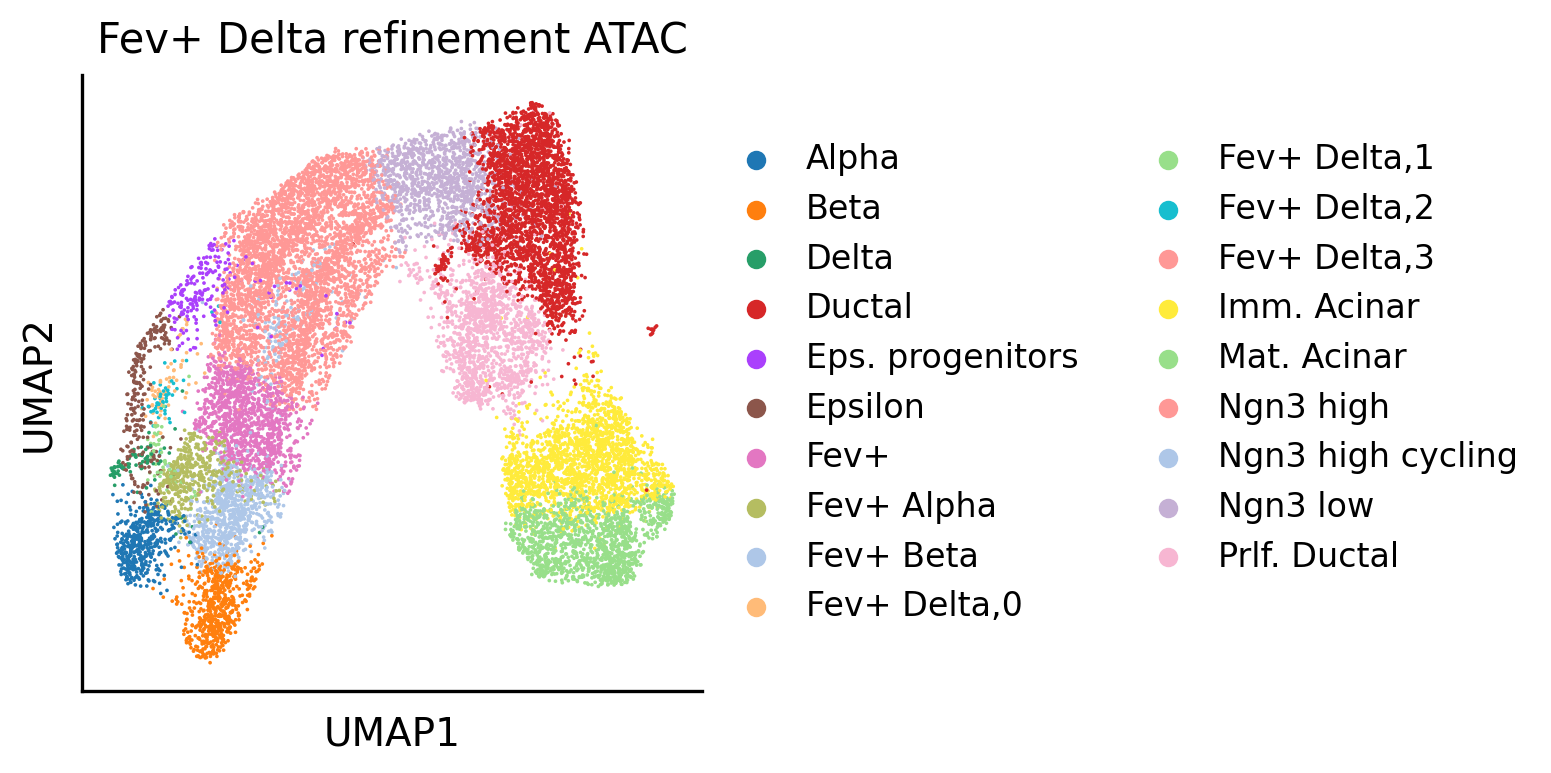

In [52]:
fig = sc.pl.embedding(adata_atac, basis="umap", color=["Fev_delta_refinement_atac"], title="Fev+ Delta refinement ATAC", show=True, return_fig=True)
fig

In [53]:
fig.figure.savefig(os.path.join(output_dir, 'fev_delta_refinement_atac.png'))

In [54]:
sc.tl.leiden(adata_atac, restrict_to=("celltype", ["Ngn3 high"]), resolution=0.7, key_added="Ngn3_high_refinement_atac")

In [55]:
adata_atac.obs["Ngn3_high_refinement_atac"].value_counts()

Ductal               2906
Imm. Acinar          1928
Prlf. Ductal         1397
Mat. Acinar          1322
Ngn3 low             1176
Ngn3 high,0          1147
Fev+                 1134
Ngn3 high,1          1022
Fev+ Beta             833
Ngn3 high,2           703
Beta                  588
Ngn3 high,3           547
Ngn3 high,4           474
Alpha                 460
Fev+ Alpha            433
Epsilon               247
Eps. progenitors      204
Fev+ Delta            176
Ngn3 high cycling     139
Delta                  77
Ngn3 high,5             4
Ngn3 high,6             1
Name: Ngn3_high_refinement_atac, dtype: int64

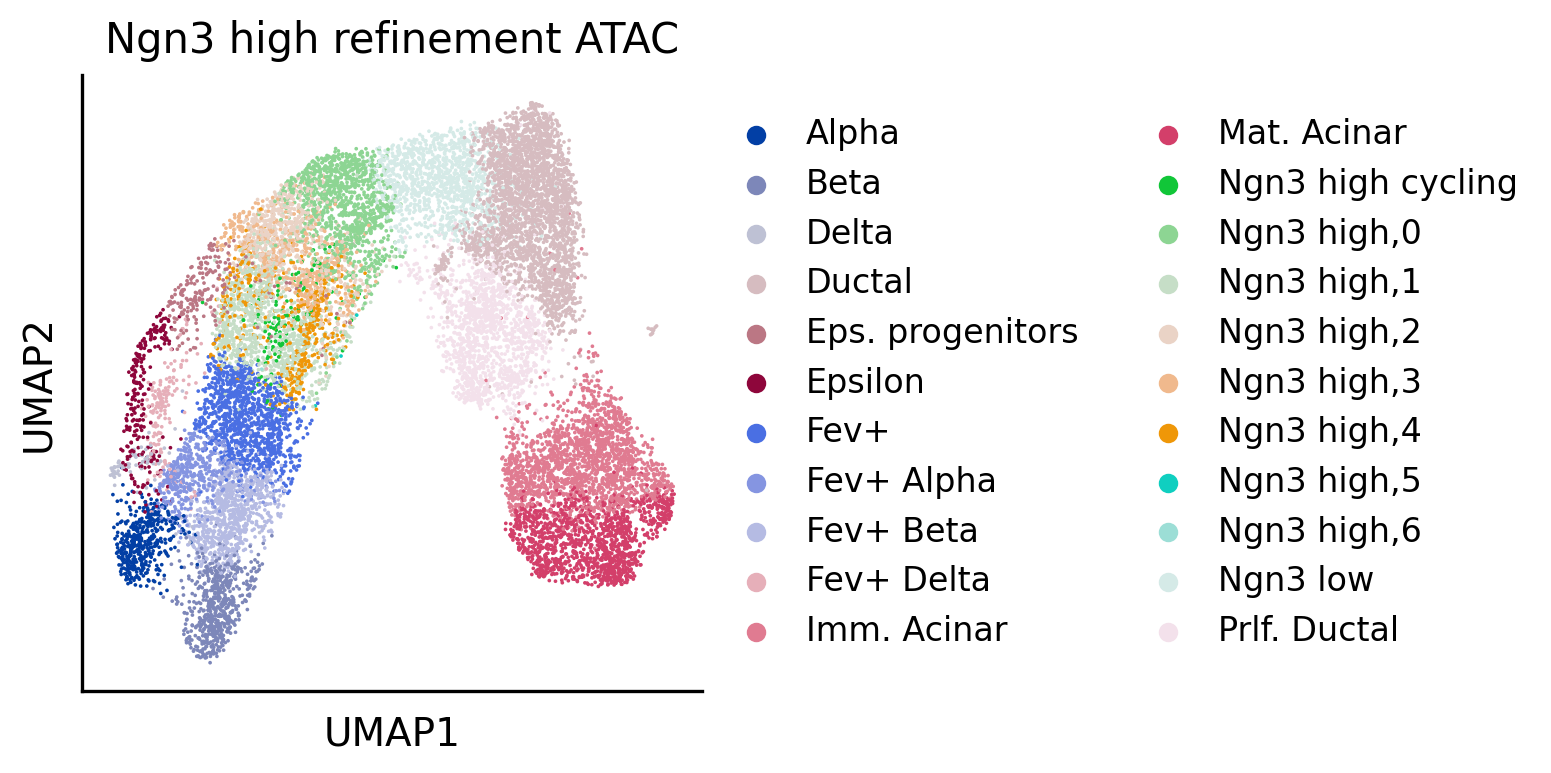

In [56]:
fig = sc.pl.embedding(adata_atac, basis="umap", color=["Ngn3_high_refinement_atac"], title="Ngn3 high refinement ATAC", show=True, return_fig=True)
fig

In [57]:
adata_atac.uns["Ngn3_high_refinement_atac_colors"] = [color_dict[ct] if ct in color_dict.keys() else orig_c for ct, orig_c in zip(adata_atac.obs["Ngn3_high_refinement_atac"].cat.categories, adata_atac.uns["Ngn3_high_refinement_atac_colors"])]

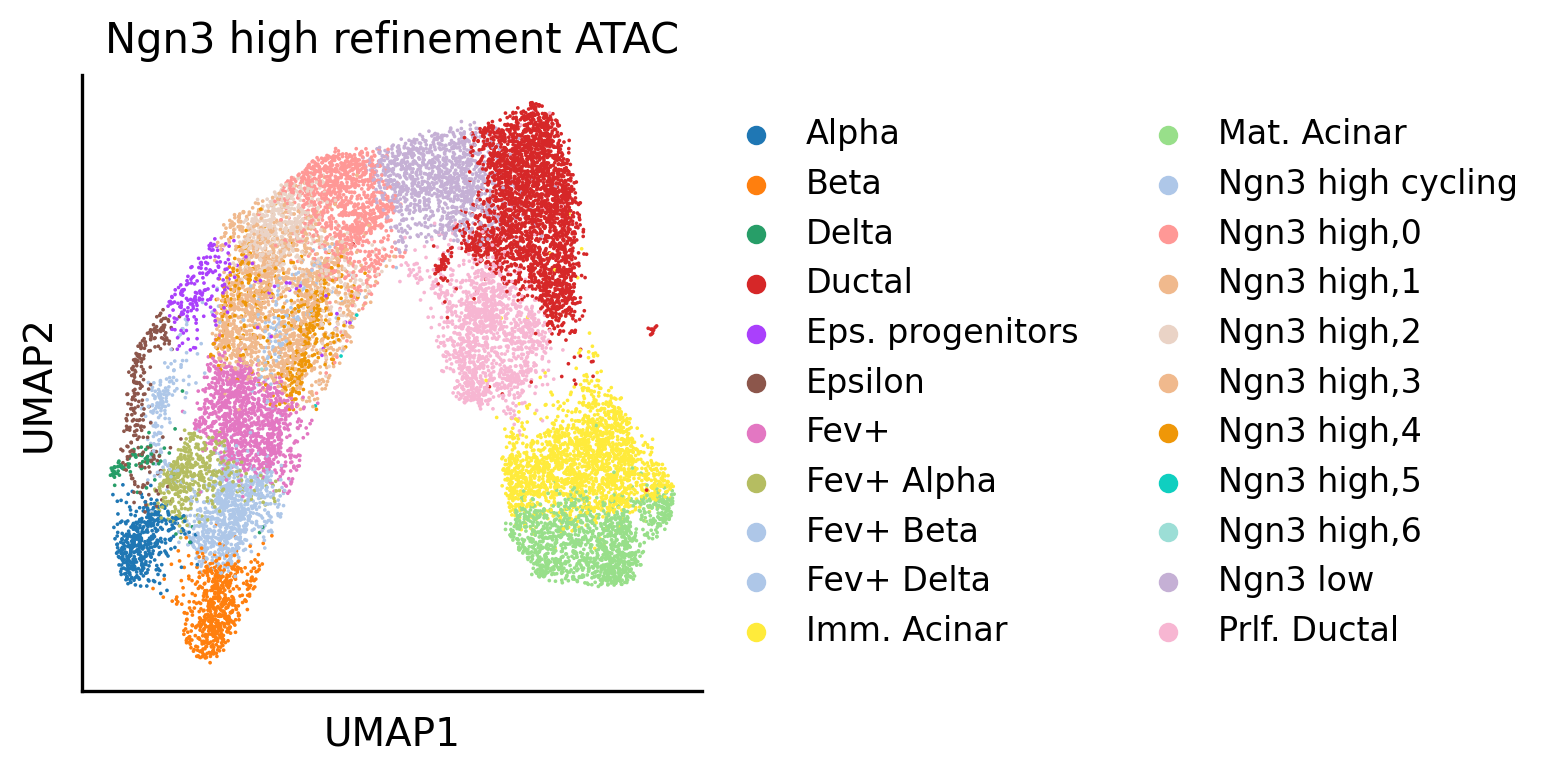

In [58]:
fig = sc.pl.embedding(adata_atac, basis="umap", color=["Ngn3_high_refinement_atac"], title="Ngn3 high refinement ATAC", show=True, return_fig=True)
fig

In [59]:
fig.figure.savefig(os.path.join(output_dir, 'ngn3_high_refinement_atac.png'))

# Export all new obs columns

In [60]:
df_joint = adata.obs[["Fev_delta_refinement", "Ngn3_high_refinement", "refinement"]]
df_gex = adata_gex.obs[["Fev_delta_refinement_gex", "Ngn3_high_refinement_gex"]]
df_atac = adata_atac.obs[["Fev_delta_refinement_atac", "Ngn3_high_refinement_atac"]]

In [61]:
df = pd.concat([df_joint, df_gex, df_atac], axis=1)

In [62]:
df.to_csv("endocrine_refinement.csv")